## use Genism and Gensim bigram for further topic modeling analysis

In [16]:
import pandas as pd  
import numpy as np 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pyLDAvis.gensim

from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords

import re
import string
import en_core_web_sm

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW

from wordcloud import WordCloud, STOPWORDS
STOPWORDS = set(STOPWORDS)   ## wordcloud stopwords

In [2]:
df=pd.read_csv('before_election.csv')

In [3]:
nlp = en_core_web_sm.load()
tokenizer=Tokenizer(nlp.vocab)
custom_stopwords=['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@','2020','election', 'vote', 'president', 'presidents', 'US', 'us', 'america', 'American', 'elections', 'campaign', 'unites state', 'unite state', 'usa','americans', 'white house', '#', 'amp', 'trump', 'biden']

In [4]:
## create a comprehensive stopewords list
sw_nltk=stopwords.words('english')
stop_words=nlp.Defaults.stop_words.union(custom_stopwords)  ##stop_words from Spacy
all_stop_words=stop_words.union(SW).union(STOPWORDS).union(sw_nltk)   # combine all stopwords from nltk, spacy, wordcloud 

In [5]:
df=df[['tweet_cleaned', 'state']]
df.dropna(subset=['tweet_cleaned'], inplace=True)

In [8]:
## Use Spacy tokenization
tokens = []

for doc in tokenizer.pipe(df['tweet_cleaned'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in all_stop_words:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [9]:
## Spacy Lemmatization
def lemma(tweet):
    lemmas=[]
    doc=nlp(tweet)
    for token in doc:
        if ((token.is_stop==False) and (token.pos_!='PRON') and (token.pos_!='VERB')):   ###remove the pron word and verb word
            lemmas.append(token.lemma_)
    return lemmas
df['lemmas']=df['tokens_back_to_text'].apply(lemma)

In [10]:
df['tweet'] = [' '.join(map(str, l)) for l in df['lemmas']]  

In [11]:
df

,tweet_cleaned,state,tokens,tokens_back_to_text,lemmas,tweet
0,elecciones florida biden dice que trump solo p...,Florida,"[elecciones, florida, dice, que, solo, preocup...",elecciones florida dice que solo preocupa por ...,"[elecciones, florida, dice, que, solo, preocup...",elecciones florida dice que solo preocupa por ...
1,islandgirlprv bradbeauregardj meidastouch bide...,Montana,"[islandgirlprv, bradbeauregardj, meidastouch, ...",islandgirlprv bradbeauregardj meidastouch trum...,"[islandgirlprv, bradbeauregardj, meidastouch, ...",islandgirlprv bradbeauregardj meidastouch trum...
2,censorship biden biden bidenemails bidenemail ...,California,"[censorship, bidenemails, bidenemail, corruption]",censorship bidenemails bidenemail corruption,"[censorship, corruption]",censorship corruption
3,nypost censorship censored twitter manipulate ...,Illinois,"[nypost, censorship, censored, twitter, manipu...",nypost censorship censored twitter manipulate ...,"[nypost, censorship, twitter, manipulate, favo...",nypost censorship twitter manipulate favor ccp...
4,fbi allegedly obtained hunter biden computer d...,Kentucky,"[fbi, allegedly, obtained, hunter, data, ukrai...",fbi allegedly obtained hunter data ukraine dea...,"[fbi, allegedly, hunter, data, ukraine, report...",fbi allegedly hunter data ukraine report claim
...,...,...,...,...,...,...
243342,appropriate since trump giving citizen big fuc...,NaN,"[appropriate, giving, citizen, big, fuckyou, t...",appropriate giving citizen big fuckyou time en...,"[appropriate, citizen, big, fuckyou, time, off...",appropriate citizen big fuckyou time office go...
243343,timobrien trump squatter tryna evade eviction,California,"[timobrien, squatter, tryna, evade, eviction]",timobrien squatter tryna evade eviction,"[timobrien, squatter, tryna, evade, eviction]",timobrien squatter tryna evade eviction
243344,bretbaier harris interviewed republican democr...,California,"[bretbaier, harris, interviewed, republican, d...",bretbaier harris interviewed republican democr...,"[bretbaier, harris, republican, democrat, vote...",bretbaier harris republican democrat voter min...
243345,trump trump maga moreyears told red wave com,Pennsylvania,"[maga, moreyears, told, red, wave]",maga moreyears told red wave,"[maga, moreyears, red, wave]",maga moreyears red wave


## Topic Modeling 

In [55]:
## create a id2word dictionary
id2word=Dictionary(df['lemmas'])

# Filtering Extreams  - use no_below to filter out words appearing less than 10 times.

id2word.filter_extremes(no_below=2, no_above=0.99)
print(len(id2word))

49110


In [56]:
# create a corpus object
corpus=[id2word.doc2bow(d) for d in df['lemmas']]

In [57]:
# Instantiate a LDA model using LDAmulticore
lda_model=LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [58]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
topics = [' '.join(t[0:20]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
people year obama supporter man care american hunter china money

------ Topic 1 ------
bidenharris maga landslide votehimout kamalaharris kag bidenharristosaveamerica electionday landslidevictory tosaveamerica

------ Topic 2 ------
covid gop republican coronavirus democrat news tax twitter pandemic new

------ Topic 3 ------
blm bidenharris voteblue que wtpblue anti msnbc wtpsenate bluewave covid

------ Topic 4 ------
debate good time people country win potus thing right year



In [59]:
## measure the model performance
base_perplexity=lda_model.log_perplexity(corpus)
## compute the coherence score (include the trump and biden as stop words)
coherence_model=CoherenceModel(model=lda_model, texts=df['lemmas'],dictionary=id2word, coherence='c_v')
coherence_lda_model_base=coherence_model.get_coherence()
print('The LDA_model Perplexity is', base_perplexity)
print('Coherence Score:', coherence_lda_model_base)

The LDA_model Perplexity is -8.461221430131262
Coherence Score: 0.3090665711523262


In [60]:
## Visulaize the topic modeling using pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.108021  0.042951       1        1  27.002486
0     -0.103590  0.070295       2        1  22.258695
2     -0.081499  0.050456       3        1  21.270666
1      0.006285 -0.224522       4        1  18.657474
3      0.286825  0.060820       5        1  10.810679, topic_info=             Term          Freq         Total Category  logprob  loglift
44    bidenharris  22734.000000  22734.000000  Default  30.0000  30.0000
216          maga  18907.000000  18907.000000  Default  29.0000  29.0000
233         covid  20102.000000  20102.000000  Default  28.0000  28.0000
137      voteblue   5840.000000   5840.000000  Default  27.0000  27.0000
1127          blm   3919.000000   3919.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
9         florida   1366.485218   4033.459821   Topic5  -5.1251   1.1423
2197       latino    685.499999    972.854733   Topic5  -5.8149   1.8745
237         state   1086.175059   5859.431969   Topic5  -5.3547   0.5392
233         covid   1431.822700  20102.599046   Topic5  -5.0784  -0.4173
165           new    856.277689   5284.728237   Topic5  -5.5925   0.4047

[453 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4184       2  0.988325   abraham
4184       4  0.004534   abraham
4184       5  0.004534   abraham
16625      2  0.983851  abruptly
100        2  0.090413   account
...      ...       ...       ...
170        1  0.011973      york
170        2  0.002395      york
170        3  0.800971      york
170        4  0.010775      york
170        5  0.173603      york

[1365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=12, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

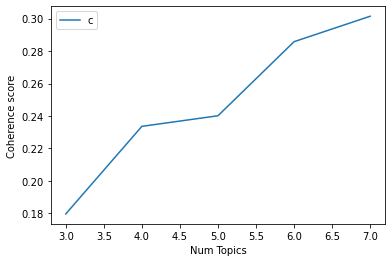

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=3, limit=8)
# Show graph
import matplotlib.pyplot as plt
limit=8; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

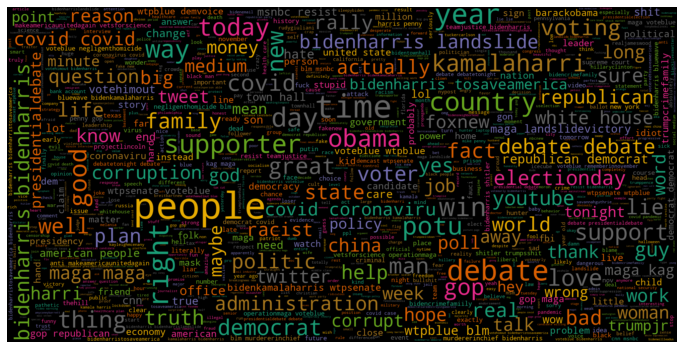

In [70]:
# wordcloud from all cleaned tweets(nouns and adjectives)
tweets_words=' '.join([text for text in df['tweet']])
wordcloud = WordCloud(width=2000, height=1000, random_state=21, max_font_size=110, #background_color='black', 
                      max_words=1000,colormap='Dark2').generate(tweets_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## try Bigram

In [42]:
from nltk import bigrams
import itertools
import collections
import networkx as nx
#tweet_bigram = [list(bigrams(tweet)) for tweet in df['lemmas']]

In [38]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*tweet_bigram))
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_df = pd.DataFrame(bigram_counts.most_common(25), columns=['bigram', 'count'])

In [39]:
len(bigram_counts)

1048214

In [41]:
bigram_df.head(30)

,bigram,count
0,"(bidenharris, bidenharris)",2011
1,"(debate, debate)",1866
2,"(bidenharris, landslide)",1756
3,"(covid, covid)",1657
4,"(white, house)",1568
5,"(maga, maga)",1533
6,"(covid, coronavirus)",1471
7,"(bidenharris, tosaveamerica)",1299
8,"(maga, kag)",1277
9,"(republican, democrat)",1245


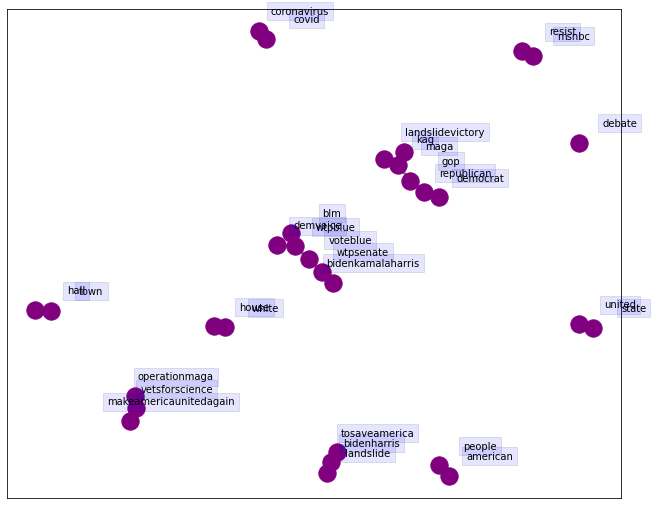

In [52]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='blue', alpha=0.1),
            horizontalalignment='center', fontsize=10)
    
plt.show()

### * From the bigram graph, the clusters of words mostly appear in the same topics.